In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

import calc_gas_collision_spectrum as calc_gas

In [71]:
import importlib
importlib.reload(utils)
importlib.reload(calc_gas)

<module 'calc_gas_collision_spectrum' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../calc_gas_collision_spectrum.py'>

In [6]:
sphere = 'sphere_20260105'
amp2kev = 6752.120154621537

def read_recon(file):
    f = h5py.File(file, 'r')

    amps = f['data_processed']['amplitude'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    # chi2 = f['data_processed']['chisquare'][:]

    f.close()

    return amps, good_detection, noise_level_amp

def get_summed_histogram(dataset, type, file_prefix, nfiles, noise_threshold_kev=200):
    bins = np.arange(0, 10000, 25)  # keV
    bc = 0.5 * (bins[:-1] + bins[1:])

    hh_all = np.zeros_like(bc, dtype=np.int64)
    pressures = []
    for i in range(nfiles):
        file = rf'/Users/yuhan/work/nanospheres/data/gas_data_processed/{sphere}/{type}/{dataset}/{file_prefix}{i}_processed.hdf5'
        amps, good_detection, noise_level_amp = read_recon(file)

        good_window = np.logical_and(good_detection, noise_level_amp*amp2kev < noise_threshold_kev)
        _hh, _ = np.histogram(np.abs(amps[good_window].flatten()) * amp2kev, bins)
        hh_all += _hh

    return bc, hh_all

In [7]:
def get_average_pressure(dataset, type, file_prefix, nfiles):
    sphere = 'sphere_20251212'
    data_dir = rf'/Volumes/LaCie/gas_collisions/{type}/{sphere}/{dataset}'

    pressures = np.empty(nfiles)
    for i in range(nfiles):
        file = os.path.join(data_dir, f'{file_prefix}{i}.hdf5')
        f = h5py.File(file, "r")

        pressures[i] = f['data'].attrs['pressure_mbar']

    return np.mean(pressures)

In [58]:
# bc, hh_all_bg_0 = get_summed_histogram('20260107_p8e_4e-8mbar', 'background_data', '20260107_df_', 150, 100)
# bc, hh_all_bg_1 = get_summed_histogram('20260107_p8e_3e-8mbar_valveclosed', 'background_data', '20260107_df_', 150, 100)

# bc, hh_all_xe_0 = get_summed_histogram('20260107_p8e_5e-8mbar', 'xenon_data', '20260107_df_', 150, 100)
# bc, hh_all_xe_1 = get_summed_histogram('20260107_p8e_6e-8mbar', 'xenon_data', '20260107_df_', 150, 100)
# bc, hh_all_xe_2 = get_summed_histogram('20260107_p8e_8e-8mbar', 'xenon_data', '20260107_df_', 150, 100)
# bc, hh_all_xe_3 = get_summed_histogram('20260107_p8e_1e-7mbar', 'xenon_data', '20260107_df_', 150, 100)
bc, hh_all_xe_4 = get_summed_histogram('20260107_p8e_2e-7mbar', 'xenon_data', '20260107_df_', 150, 100)

In [89]:
sig_p_kev = 70
qq_kev = np.linspace(1, 10000, 10000)

dr_dq_diffuse_xe = calc_gas.dgamma_dp_diffuse(qq_kev, calc_gas.A, 131.3, 2e-7, 293, 1000, 50e-9)
dr_dq_xe = calc_gas.dgamma_dp(qq_kev, calc_gas.A, 131.3, 2e-7, 1, 293, 50e-9)

qqz, drdqz = calc_gas.get_drdqz(qq_kev, dr_dq_xe)
qqz, drdqz_diffuse = calc_gas.get_drdqz(qq_kev, dr_dq_diffuse_xe)

qqzn, drdqzn_xe = calc_gas.smear_drdqz_gauss(qqz, drdqz, sig_p_kev)
qqzn, drdqzn_diffuse_xe = calc_gas.smear_drdqz_gauss(qqz, drdqz_diffuse, sig_p_kev)

Text(0, 0.5, 'Counts/(50 keV/c)/s')

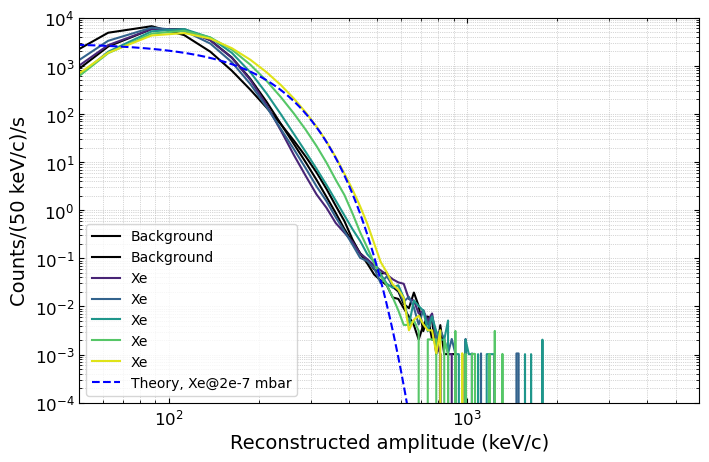

In [92]:
# cmap = plt.colormaps.get_cmap('Greys')
# colors_bg = cmap((np.log(np.asarray([p_bg_0, p_bg_1, p_bg_2, p_bg_3, p_bg_4, p_bg_5])) - np.log(2e-8)) / (np.log(2e-7) - np.log(2e-8)))

plt.figure(figsize=(8, 5))
plt.plot(bc, hh_all_bg_0/(50e-6 * np.sum(hh_all_bg_0)), color='k', label=f'Background')
plt.plot(bc, hh_all_bg_1/(50e-6 * np.sum(hh_all_bg_1)), color='k', label=f'Background')

plt.plot(bc, hh_all_xe_0/(50e-6 * np.sum(hh_all_xe_0)), label=f'Xe')
plt.plot(bc, hh_all_xe_1/(50e-6 * np.sum(hh_all_xe_1)), label=f'Xe')
plt.plot(bc, hh_all_xe_2/(50e-6 * np.sum(hh_all_xe_2)), label=f'Xe')
plt.plot(bc, hh_all_xe_3/(50e-6 * np.sum(hh_all_xe_3)), label=f'Xe')
plt.plot(bc, hh_all_xe_4/(50e-6 * np.sum(hh_all_xe_4)), label=f'Xe')


# sigma = 72.5
# xx = np.logspace(-2, 4, 200)
# half_gauss_amp = 50 * 2 * np.sum(hh_all_bg_0/(50e-6 * np.sum(hh_all_bg_0))) / (sigma * np.sqrt(2 * np.pi))
# plt.plot(xx, utils.gauss(xx, half_gauss_amp, 0, sigma), '-', color='#FD1D1D', label=rf'$\sigma_p=${sigma} keV')

plt.plot(qq_kev, drdqzn_xe*50, 'b--', label='Theory, Xe@2e-7 mbar')

plt.xlim(50, 6000)
plt.ylim(1e-4, 1e4)
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', ls=':', linewidth=0.5)

plt.legend(fontsize=10, loc=3)

plt.xlabel('Reconstructed amplitude (keV/c)')
plt.ylabel('Counts/(50 keV/c)/s')
